## Installing Packages


In [6]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
!pip install --upgrade geopandas mapclassify folium

from IPython.display import Image
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import mapclassify
import folium

!pip install arcgis --no-deps
!pip install ujson requests_toolbelt requests_ntlm geomet
!pip install cachetools requests_oauthlib

import arcgis 
import time
import csv 

from arcgis.gis import GIS 
import sys
from arcgis.geocoding import geocode
from arcgis.geocoding import analyze_geocode_input

import requests
import logging

logger = logging.getLogger("root")
logger.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
logger.addHandler(ch)

arcgis.geocoding.get_geocoders(GIS())

Connecting to portal: www.arcgis.com
Connecting to portal: www.arcgis.com
Starting new HTTPS connection (1): www.arcgis.com:443
Starting new HTTPS connection (1): www.arcgis.com:443
https://www.arcgis.com:443 "GET /sharing/info?f=json HTTP/1.1" 200 84
https://www.arcgis.com:443 "GET /sharing/info?f=json HTTP/1.1" 200 84
https://www.arcgis.com:443 "GET /sharing/rest/info?f=json HTTP/1.1" 200 None
https://www.arcgis.com:443 "GET /sharing/rest/info?f=json HTTP/1.1" 200 None
https://www.arcgis.com:443 "GET /sharing/sharing/rest/info?f=json HTTP/1.1" 200 84
https://www.arcgis.com:443 "GET /sharing/sharing/rest/info?f=json HTTP/1.1" 200 84
https://www.arcgis.com:443 "GET /sharing/rest/services?f=json HTTP/1.1" 200 84
https://www.arcgis.com:443 "GET /sharing/rest/services?f=json HTTP/1.1" 200 84
Starting new HTTPS connection (1): www.arcgis.com:443
Starting new HTTPS connection (1): www.arcgis.com:443
https://www.arcgis.com:443 "POST /sharing/rest/portals/self HTTP/1.1" 200 None
https://www.a

[<Geocoder url:"https://geocode.arcgis.com/arcgis/rest/services/World/GeocodeServer">]

## Importing and Examining the Data


In [7]:
# import data via csv. For some reason the nyc opendata API will only give me 1000 records??

crashes = pd.read_csv('Motor_Vehicle_Collisions_-_Crashes_20240126.csv')

In [15]:
crashes.shape

(2060767, 29)

In [17]:
pd.options.display.max_columns=100
pd.options.display.max_rows=100
crashes.head(10)

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,2.0,0.0,0,0,0,0,2,0,Aggressive Driving/Road Rage,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,1.0,0.0,0,0,0,0,1,0,Pavement Slippery,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Following Too Closely,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
3,09/11/2021,9:35,BROOKLYN,11208.0,40.667202,-73.866500,"(40.667202, -73.8665)",NaN,NaN,1211 LORING AVENUE,0.0,0.0,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4456314,Sedan,NaN,NaN,NaN,NaN
4,12/14/2021,8:13,BROOKLYN,11233.0,40.683304,-73.917274,"(40.683304, -73.917274)",SARATOGA AVENUE,DECATUR STREET,NaN,0.0,0.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,4486609,NaN,NaN,NaN,NaN,NaN
5,04/14/2021,12:47,NaN,NaN,NaN,NaN,NaN,MAJOR DEEGAN EXPRESSWAY RAMP,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,4407458,Dump,Sedan,NaN,NaN,NaN
6,12/14/2021,17:05,NaN,NaN,40.709183,-73.956825,"(40.709183, -73.956825)",BROOKLYN QUEENS EXPRESSWAY,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Passing Too Closely,Unspecified,NaN,NaN,NaN,4486555,Sedan,Tractor Truck Diesel,NaN,NaN,NaN
7,12/14/2021,8:17,BRONX,10475.0,40.868160,-73.831480,"(40.86816, -73.83148)",NaN,NaN,344 BAYCHESTER AVENUE,2.0,0.0,0,0,0,0,2,0,Unspecified,Unspecified,NaN,NaN,NaN,4486660,Sedan,Sedan,NaN,NaN,NaN
8,12/14/2021,21:10,BROOKLYN,11207.0,40.671720,-73.897100,"(40.67172, -73.8971)",NaN,NaN,2047 PITKIN AVENUE,0.0,0.0,0,0,0,0,0,0,Driver Inexperience,Unspecified,NaN,NaN,NaN,4487074,Sedan,NaN,NaN,NaN,NaN
9,12/14/2021,14:58,MANHATTAN,10017.0,40.751440,-73.973970,"(40.75144, -73.97397)",3 AVENUE,EAST 43 STREET,NaN,0.0,0.0,0,0,0,0,0,0,Passing Too Closely,Unspecified,NaN,NaN,NaN,4486519,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN


The first thing I notice upon examining the data is a data quality issue. Most records come with a lat/long, which is great, but some don't. It also looks like the police occasionally input (0,0) for latlong when they mean is they don't know the latlong - but that maps to null island! This means I will have to use a geocoder to get latlongs for those records with no given coordinates or zero coordinates. This should be doable because if they don't have a latlong the police usually record at least a cross street or even a street address. However, the fact that borough and zip code are so sparsely recorded may make this harder.

In [14]:
#subset to serious pedestrian crashes - those crashes that resulted in at least one pedestrian death or injury. This is what i'm ultimately interested in so it makes sense to subset before I geocode, which will take a long time.

crashes_pedestrian = crashes[(crashes['NUMBER OF PEDESTRIANS INJURED'] > 0) | (crashes['NUMBER OF PEDESTRIANS KILLED'] > 0)]

In [15]:
#Check how many records out of the total I will have to geocode. About 7 percent of them! Not a ton but probably worth doing, especially if there's a pattern to the records with unrecorded latlongs.

print(len(crashes_pedestrian))
print(len(crashes_pedestrian[pd.isnull(crashes_pedestrian['LATITUDE'])]))

112389
7951


## Geocoding the data

I tried geocoding with both the ESRI and the google geocoder - google is supposedly much faster but it took 40 minutes to ESRI's hour! And the google results were much less accurate - it had a hard time recognizing intersections. This could have something to do with how I formatted the url. Anyway, I only include code here for the ESRI geocoder because that's what I ended up using.

In [ ]:
#write a for-loop to geocode the records with no latlong using the esri geocoder. This took about an hour to run.

input_rows_geocoded = []

for idx, crash in crashes_pedestrian.iterrows():
    if pd.isnull(crash['LATITUDE']) or crash['LATITUDE'] == 0:
        crash_geocoded = crash
        geocodeoutput = geocode(str(crash['ON STREET NAME']) + '&' + str(crash['CROSS STREET NAME']) + ',' + str(crash['OFF STREET NAME']) + ',' + str(crash['BOROUGH']) + "," + "NEW YORK" + "," + str(crash['ZIP CODE']))[0]
        crash_geocoded['LONGITUDE'] = geocodeoutput['attributes']['DisplayX'] 
        crash_geocoded['LATITUDE'] = geocodeoutput['attributes']['DisplayY'] 
        crash_geocoded['ESRI_Match_Score'] = geocodeoutput['score'] 
        crash_geocoded['ESRI_Match_Type'] = geocodeoutput['attributes']['Addr_type']
    else:
        crash_geocoded = crash
        input_rows_geocoded.append(crash_geocoded)


In [184]:
#convert to df
geocoded_df = pd.DataFrame(input_rows_geocoded)

In [185]:
len(geocoded_df)

110916

In [186]:
#write to csv so I never have to run that code cell again
geocoded_df.to_csv('geocoded_crashes.csv')

In [8]:
geocoded_df = pd.read_csv('geocoded_crashes.csv')

In [165]:
geocoded_df.head(50)

,Unnamed: 0,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,ESRI_Match_Score,ESRI_Match_Type
0,23,12/14/2021,3:43,NaN,NaN,40.804375,-73.937420,"(40.804375, -73.93742)",LEXINGTON AVENUE,NaN,NaN,1.0,0.0,1,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4486304,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,NaN,NaN
1,25,12/14/2021,17:31,BROOKLYN,11230.0,40.623104,-73.958090,"(40.623104, -73.95809)",EAST 18 STREET,AVENUE K,NaN,1.0,0.0,1,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4486516,Sedan,NaN,NaN,NaN,NaN,NaN,NaN
2,33,12/16/2021,6:59,NaN,NaN,40.722230,-73.941090,NaN,KINGSLAND AVENUE,MEEKER AVENUE,NaN,1.0,0.0,1,0,0,0,0,0,Traffic Control Disregarded,NaN,NaN,NaN,NaN,4486960,NaN,NaN,NaN,NaN,NaN,97.91,StreetInt
3,39,07/09/2021,0:43,NaN,NaN,40.720535,-73.888850,"(40.720535, -73.88885)",ELIOT AVENUE,NaN,NaN,0.0,1.0,0,1,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4456659,Bus,NaN,NaN,NaN,NaN,NaN,NaN
4,42,04/22/2022,17:17,NaN,NaN,40.790276,-73.939600,"(40.790276, -73.9396)",EAST 107 STREET,NaN,NaN,1.0,0.0,1,0,0,0,0,0,Traffic Control Disregarded,NaN,NaN,NaN,NaN,4522226,E-Bike,NaN,NaN,NaN,NaN,NaN,NaN
5,57,04/12/2022,19:56,BROOKLYN,11203.0,40.650110,-73.930214,"(40.65011, -73.930214)",UTICA AVENUE,SNYDER AVENUE,NaN,1.0,0.0,1,0,0,0,0,0,Failure to Yield Right-of-Way,NaN,NaN,NaN,NaN,4522136,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,NaN,NaN
6,90,12/09/2021,0:00,NaN,NaN,40.744800,-73.953415,"(40.7448, -73.953415)",47 ROAD,NaN,NaN,1.0,0.0,1,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4485384,Sedan,NaN,NaN,NaN,NaN,NaN,NaN
7,109,03/24/2022,23:00,BRONX,10472.0,40.829777,-73.850550,"(40.829777, -73.85055)",WATSON AVENUE,CASTLE HILL AVENUE,NaN,1.0,0.0,1,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4514182,Sedan,NaN,NaN,NaN,NaN,NaN,NaN
8,111,03/26/2022,11:50,BROOKLYN,11236.0,40.635563,-73.895770,"(40.635563, -73.89577)",EAST 94 STREET,AVENUE M,NaN,2.0,0.0,2,0,0,0,0,0,Failure to Yield Right-of-Way,NaN,NaN,NaN,NaN,4513663,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,NaN,NaN
9,116,03/26/2022,22:51,NaN,NaN,40.749670,-73.995310,"(40.74967, -73.99531)",WEST 30 STREET,NaN,NaN,1.0,0.0,1,0,0,0,0,0,Failure to Yield Right-of-Way,NaN,NaN,NaN,NaN,4513606,Sedan,NaN,NaN,NaN,NaN,NaN,NaN


## Judging match quality

One risk of geocoding is that you can end up with bad points. I'll need to discard these so that they don't mess up my analysis. But how do I determine which points are bad? Luckily, ESRI gives you a 'match score' for each result. The received wisdom is that a score of 97 or above is good. Let's see how many of those I have! 

<Axes: >

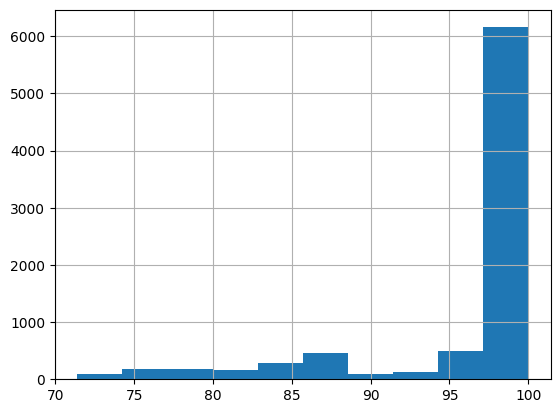

In [180]:
#Look at the distribution of ESRI match scores. 
geocoded_df['ESRI_Match_Score'].hist()

In [181]:
#How many records do I keep if I use 97 as a threshold? How many do I lose?

print(len(geocoded_df[geocoded_df['ESRI_Match_Score']>=97]))
print(len(geocoded_df[geocoded_df['ESRI_Match_Score']<97]))

6303
1918


In [169]:
#Not terrible, but might be worth checking out the records I'm going to discard to see if there's any saving them.

#Records with a score between 95 and 97 look pretty solid. They are street intersections or even point adddresses. Some spotchecking reveals their latlongs to be very reasonable. I will keep these.

#Some of these would have better matches if we knew the zip or even the borough, but we don't, and there's nothing I can do about that.

#Final thought: there should be some reckoning as to "east drive" and "west drive." These appear to be the names of roads in both Central Park and Prospect Park and it seems most of the records with these addresses are bike accidents. The geocoder has a hard time with these so the final dataset may underrepresent pedestrian/bike collisions.

pd.options.display.max_columns=100
pd.options.display.max_rows=200

geocoded_df[(geocoded_df['ESRI_Match_Score'] <97) & pd.notna(geocoded_df['ESRI_Match_Score'])].head(200)

,Unnamed: 0,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,ESRI_Match_Score,ESRI_Match_Type,geometry
32,384,07/04/2021,22:22,NaN,NaN,40.834730,-73.821520,NaN,LAYTON AVENUE,THROGMORTAN AVENUE,NaN,1.0,0.0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,4456568,NaN,NaN,NaN,NaN,NaN,96.76,StreetInt,POINT (-73.82152 40.83473)
59,761,04/06/2021,16:00,NaN,NaN,40.679202,-73.953075,"(0.0, 0.0)",BEDFORD AVENUE,NaN,NaN,1.0,0.0,1,0,0,0,0,0,Driver Inattention/Distraction,NaN,NaN,NaN,NaN,4408107,Bus,NaN,NaN,NaN,NaN,86.88,StreetName,POINT (-73.95307 40.67920)
281,4088,12/17/2021,22:15,NaN,NaN,40.885930,-73.896530,NaN,VANCORTLANDT PARK,INTERSTATE ROUTE 87 NORTH,NaN,1.0,0.0,1,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4487350,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,80.88,StreetInt,POINT (-73.89653 40.88593)
291,4197,09/10/2021,9:33,NaN,NaN,40.641370,-73.941770,NaN,FLATLAND AVENUE,EAST 37 STREET,NaN,1.0,0.0,1,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,4457879,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,95.27,StreetInt,POINT (-73.94177 40.64137)
358,5185,04/22/2021,9:17,MANHATTAN,10002.0,40.716980,-73.982280,NaN,delancey street,bialystoker place,NaN,1.0,0.0,1,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4409593,Sedan,NaN,NaN,NaN,NaN,96.99,StreetInt,POINT (-73.98228 40.71698)
386,5432,12/15/2021,7:50,NaN,NaN,40.648115,-73.803089,NaN,VANWYCK EXPRESSWAY,NaN,NaN,1.0,0.0,1,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4486739,Sedan,NaN,NaN,NaN,NaN,88.33,StreetName,POINT (-73.80309 40.64811)
459,6577,12/18/2021,17:30,NaN,NaN,40.818340,-73.926360,NaN,EAST 149 STREET,ANTHONY A GRIFFIN,NaN,1.0,0.0,1,0,0,0,0,0,Failure to Yield Right-of-Way,NaN,NaN,NaN,NaN,4488011,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,96.26,StreetInt,POINT (-73.92636 40.81834)
482,6912,04/13/2021,11:40,BROOKLYN,11217.0,40.685310,-73.975019,NaN,NaN,NaN,62 Hanson,1.0,0.0,1,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4411394,Sedan,NaN,NaN,NaN,NaN,95.89,PointAddress,POINT (-73.97502 40.68531)
543,7848,09/17/2021,15:50,NaN,NaN,40.653893,-73.964353,NaN,PARKSIDE AVENUE,NaN,NaN,1.0,0.0,1,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4458255,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,87.27,StreetName,POINT (-73.96435 40.65389)
569,8287,09/16/2021,10:00,NaN,NaN,40.836222,-73.918578,NaN,WALTON AVENUE,NaN,NaN,1.0,0.0,1,0,0,0,0,0,View Obstructed/Limited,NaN,NaN,NaN,NaN,4458052,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,86.45,StreetName,POINT (-73.91858 40.83622)


In [183]:
#save records with match score above 95
crashes_df = geocoded_df[(geocoded_df['ESRI_Match_Score'] > 95) | pd.isnull(geocoded_df['ESRI_Match_Score'])]

len(crashes_df)

109294

In [184]:
crashes_df.to_csv('geocoded_crashes_final.csv')